<a href="https://colab.research.google.com/github/kwingithub/projects/blob/main/Smart_Health_Insurance_Pricing_Simulation_with_Subgroup_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Smart Health Insurance Pricing Simulation with Subgroup Analysis


Pipeline:   0%|          | 0/4 [00:00<?, ?it/s]

Simulation Rounds:   0%|          | 0/12 [00:00<?, ?it/s]

Round 1 Agents:   0%|          | 0/100 [00:00<?, ?it/s]

Round 1: Active=100, AvgRisk=51.18, AvgPrem=¥505.89


Round 2 Agents:   0%|          | 0/100 [00:00<?, ?it/s]

Round 2: Active=100, AvgRisk=52.68, AvgPrem=¥513.38


Round 3 Agents:   0%|          | 0/100 [00:00<?, ?it/s]

Round 3: Active=100, AvgRisk=53.96, AvgPrem=¥519.77


Round 4 Agents:   0%|          | 0/100 [00:00<?, ?it/s]

Round 4: Active=100, AvgRisk=55.55, AvgPrem=¥527.73


Round 5 Agents:   0%|          | 0/100 [00:00<?, ?it/s]

Round 5: Active=100, AvgRisk=57.13, AvgPrem=¥535.64


Round 6 Agents:   0%|          | 0/100 [00:00<?, ?it/s]

Round 6: Active=100, AvgRisk=58.75, AvgPrem=¥543.71


Round 7 Agents:   0%|          | 0/100 [00:00<?, ?it/s]

Round 7: Active=100, AvgRisk=60.28, AvgPrem=¥551.36


Round 8 Agents:   0%|          | 0/100 [00:00<?, ?it/s]

Round 8: Active=100, AvgRisk=61.85, AvgPrem=¥559.23


Round 9 Agents:   0%|          | 0/100 [00:00<?, ?it/s]

Round 9: Active=100, AvgRisk=63.50, AvgPrem=¥567.49


Round 10 Agents:   0%|          | 0/100 [00:00<?, ?it/s]

Round 10: Active=100, AvgRisk=64.96, AvgPrem=¥574.78


Round 11 Agents:   0%|          | 0/100 [00:00<?, ?it/s]

Round 11: Active=100, AvgRisk=66.43, AvgPrem=¥582.12


Round 12 Agents:   0%|          | 0/100 [00:00<?, ?it/s]

Round 12: Active=100, AvgRisk=67.97, AvgPrem=¥589.85


SubgroupAnalysis Rounds:   0%|          | 0/12 [00:00<?, ?it/s]

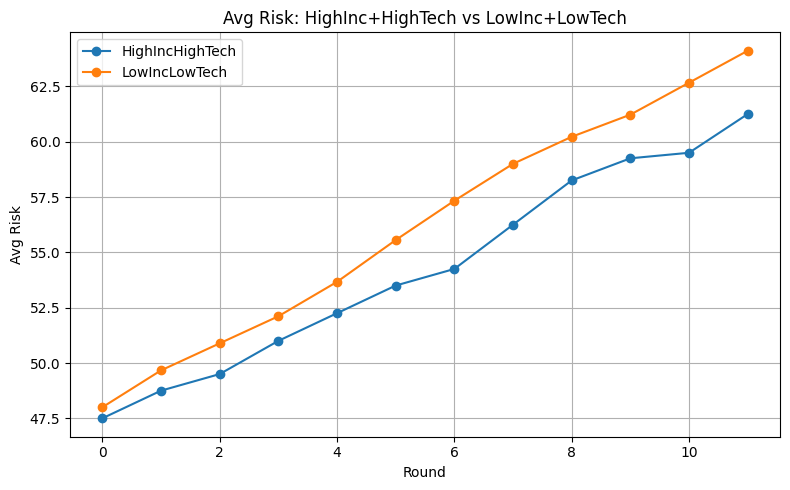

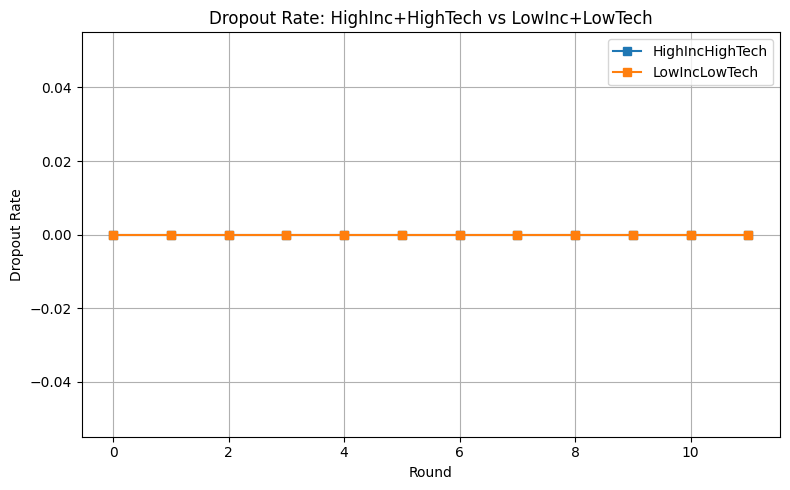

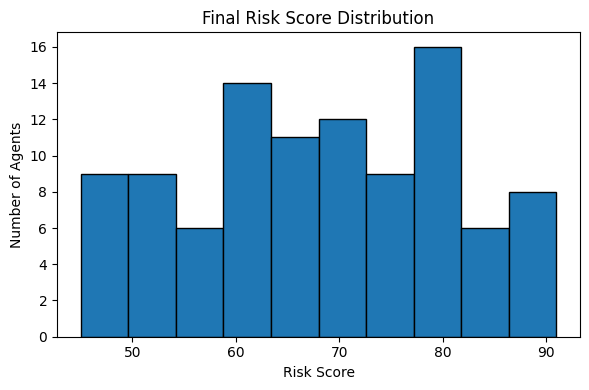


Sample agent dialogues:
Agent 76: ['Given your **actual profile** (Young, Low Income, Medium Tech Savviness, Low Insurance Literacy, Current Health Risk: 60, Healthy Behavior Tendency, Goal: Risk ≤30), here’s the **best action and rationale**:\n\n---\n\n### **Recommended Action: Option 1 (Exercise + Diet + Respond to Incentive)**  \n\n#### **Why This Fits You Best:**  \n1. **Balanced Risk Reduction (60 → ≤30):**  \n   - Your **current risk (60)** is double your goal, but your **healthy behavior tendency** means you’re already inclined toward positive habits. Combining **exercise + diet** with the **incentive (Points+Cashback, Strength 5)**', 'Given your **actual profile** (Young, Low Income, Medium Tech Savviness, Low Insurance Literacy, Current Health Risk: 61, Healthy Behavior Tendency, Goal: Risk ≤30, Recent Incentive Response: False, Platform Incentive: Points+Cashback [Strength 5]), here’s the **best action and rationale**:\n\n---\n\n### **Recommended Action: Option 1 (Exercise +

In [ ]:
# =====================
# Colab Notebook: Smart Health Insurance Pricing Simulation
# with Nested tqdm Progress Bars and Logging
# =====================

# 1. Install dependencies (uncomment in Colab)
# !pip install openai networkx matplotlib pandas tqdm

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import logging
from tqdm.auto import tqdm
from openai import OpenAI

# —— Global settings ——
DEBUG = True              # Log every LLM reply to dialogue_debug.log
MAX_DIALOGUE = 3          # Keep this many recent dialogues per agent

# 2. Configure logging to file
logging.basicConfig(
    filename="dialogue_debug.log",
    filemode="w",
    level=logging.INFO,
    format="%(message)s"
)

# 3. Initialize OpenAI client
client = OpenAI(
    api_key="sk-bf3c62c2c965429cbe28526a475e8aef",
    base_url="https://api.deepseek.com"
)

# 4. Simulation parameters
NUM_AGENTS = 100
NUM_ROUNDS = 12
SAVE_DIR = "figures"
os.makedirs(SAVE_DIR, exist_ok=True)


# =====================
# Part 1: Agent Definition
# =====================
class UserAgent:
    def __init__(self, uid, archetype):
        # Profile attributes
        self.uid = uid
        self.age_group = archetype["age_group"]
        self.profession = archetype["profession"]
        self.health_status = archetype["health_status"]
        self.behavior_tendency = archetype["behavior"]
        self.incentive_sensitivity = archetype["incentive_sens"]
        self.income_level = archetype["income"]
        self.tech_level = archetype["tech"]
        self.dependents = archetype["dependents"]
        self.insurance_literacy = archetype["literacy"]
        # Internal state
        self.risk_score = random.randint(30, 70)
        self.base_premium = 500
        self.current_premium = self.base_premium
        self.is_enrolled = True
        # Histories
        self.risk_history = []
        self.premium_history = []
        self.enrollment_history = []
        self.behavior_history = []
        self.dialogue_history = []
        self.incentive_memory = []

    def decide_action(self, incentive, peer_messages):
        if not self.is_enrolled:
            self.enrollment_history.append(False)
            return "Dropped"
        prompt = (
            f"You are a health insurance user with this profile:\n"
            f"- Age group: {self.age_group}\n"
            f"- Income level: {self.income_level}\n"
            f"- Tech savviness: {self.tech_level}\n"
            f"- Insurance literacy: {self.insurance_literacy}\n"
            f"- Current health risk: {self.risk_score}\n"
            f"- Current premium: ¥{self.current_premium}\n"
            f"- Behavior tendency: {self.behavior_tendency}\n"
            f"- Goal: keep risk <= 30\n\n"
            f"Recent incentive response: {self.incentive_memory[-1] if self.incentive_memory else 'None'}\n"
            f"Platform incentive: {incentive['type']} (Strength {incentive['strength']})\n"
            f"Peer messages:\n{peer_messages if peer_messages else '(none)'}\n\n"
            f"Select action (1-5) and explain:\n"
            f"1. Exercise + Diet + Respond to incentive\n"
            f"2. Exercise + Diet only\n"
            f"3. Respond to incentive (health checkup)\n"
            f"4. Do nothing\n"
            f"5. Drop out of plan\n"
        )
        try:
            response = client.chat.completions.create(
                model="deepseek-chat",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.7,
                max_tokens=150
            )
            reply = response.choices[0].message.content.strip()
            if DEBUG:
                logging.info(f"[Agent {self.uid} LLM reply]\n{reply}\n")
        except Exception:
            if DEBUG:
                logging.info(f"[Agent {self.uid} LLM ERROR, using fallback]\n")
            return self._fallback_action(incentive)

        # Record dialogue
        self.dialogue_history.append(reply)
        if len(self.dialogue_history) > MAX_DIALOGUE:
            self.dialogue_history.pop(0)

        # Parse action
        if reply.startswith("1"):
            action = "Exercise+Diet+Incentive"
        elif reply.startswith("2"):
            action = "Exercise+Diet"
        elif reply.startswith("3"):
            action = "Checkup+Incentive"
        elif reply.startswith("5"):
            self.is_enrolled = False
            action = "Dropped"
        else:
            action = "DoNothing"

        # Update memories and logs
        self.behavior_history.append(action)
        self.incentive_memory.append("Incentive" in action)
        self.enrollment_history.append(self.is_enrolled)
        return action

    def _fallback_action(self, incentive):
        base = random.random()
        strength = incentive["strength"]
        if self.current_premium > 650 and self.income_level == "Low" and base < 0.2:
            self.is_enrolled = False
            return "Dropped"
        if self.behavior_tendency == "Healthy":
            return ("Exercise+Diet+Incentive"
                    if strength * self.incentive_sensitivity + base > 0.5
                    else "Exercise+Diet")
        return ("Checkup+Incentive"
                if strength * self.incentive_sensitivity + base > 0.7
                else "DoNothing")

    def update_status(self, action):
        # Health update with noise
        if action != "Dropped":
            change = ((-3 if "Exercise" in action else 0)
                      + (-2 if "Diet" in action else 0)
                      + (-1 if "Checkup" in action else 0)
                      + (2 if action == "DoNothing" else 0))
            noise = np.random.normal(0, 1)
            self.risk_score = int(np.clip(self.risk_score + change + noise, 0, 100))
        self.risk_history.append(self.risk_score)

        # Premium update
        if not self.is_enrolled:
            self.current_premium = 0
        else:
            self.current_premium = int(
                self.base_premium * (1 + (self.risk_score - 50) / 100)
            )
        self.premium_history.append(self.current_premium)


# =====================
# Part 2: Helpers
# =====================
def generate_archetype():
    return {
        "age_group": random.choices(
            ["Young", "Middle-aged", "Senior"], [30, 50, 20]
        )[0],
        "profession": random.choice(["Office", "Labor", "Retired", "Gig", "Teacher"]),
        "health_status": random.choices(
            ["Good", "Medium", "Poor"], [25, 50, 25]
        )[0],
        "behavior": random.choices(
            ["Healthy", "Indulgent", "Passive"], [40, 40, 20]
        )[0],
        "incentive_sens": round(random.uniform(0.3, 0.9), 2),
        "income": random.choices(["High", "Medium", "Low"], [15, 50, 35])[0],
        "tech": random.choices(["High", "Medium", "Low"], [30, 50, 20])[0],
        "dependents": random.choices([0, 1, 2, 3], [25, 35, 25, 15])[0],
        "literacy": random.choices(["High", "Medium", "Low"], [20, 50, 30])[0]
    }

def build_social_network(n):
    return nx.erdos_renyi_graph(n, p=0.05)

def incentive_policy(round_index):
    return {
        "type": "Points+Cashback",
        "strength": 2 if round_index < 5 else 5
    }


# =====================
# Part 3–6: Pipeline
# =====================
# Initialize agents & network
agents = [UserAgent(i, generate_archetype()) for i in range(NUM_AGENTS)]
network = build_social_network(NUM_AGENTS)

# Prepare for subgroup analysis
subgroups = {
    "Young": lambda a: a.age_group == "Young",
    "Middle-aged": lambda a: a.age_group == "Middle-aged",
    "Senior": lambda a: a.age_group == "Senior",
    "HighIncHighTech": lambda a: a.income_level == "High"
                          and a.tech_level == "High",
    "LowIncLowTech":   lambda a: a.income_level == "Low"
                          and a.tech_level == "Low"
}
subgroup_metrics = {
    name: {"risk": [], "premium": [], "dropout": []}
    for name in subgroups
}

# Pipeline phases
for phase in tqdm(
    ["Simulation", "SubgroupAnalysis", "Visualization", "Export"],
    desc="Pipeline"
):
    if phase == "Simulation":
        for r in tqdm(range(NUM_ROUNDS), desc="Simulation Rounds", leave=False):
            incentive = incentive_policy(r)
            for agent in tqdm(agents, desc=f"Round {r+1} Agents", leave=False):
                if agent.is_enrolled:
                    peers = [
                        agents[n].dialogue_history[-1]
                        for n in network.neighbors(agent.uid)
                        if agents[n].dialogue_history
                    ]
                    action = agent.decide_action(incentive, "\n".join(peers))
                    agent.update_status(action)
            active = sum(a.enrollment_history[r] for a in agents)
            avg_risk = np.mean(
                [a.risk_history[r] for a in agents if a.enrollment_history[r]]
            )
            avg_prem = np.mean(
                [a.premium_history[r] for a in agents if a.enrollment_history[r]]
            )
            print(
                f"Round {r+1}: Active={active}, "
                f"AvgRisk={avg_risk:.2f}, AvgPrem=¥{avg_prem:.2f}"
            )

    elif phase == "SubgroupAnalysis":
        for r in tqdm(range(NUM_ROUNDS),
                      desc="SubgroupAnalysis Rounds",
                      leave=False):
            for name, cond in subgroups.items():
                grp = [a for a in agents if cond(a)]
                if not grp:
                    subgroup_metrics[name]["risk"].append(np.nan)
                    subgroup_metrics[name]["premium"].append(np.nan)
                    subgroup_metrics[name]["dropout"].append(np.nan)
                    continue
                risks = [a.risk_history[r] for a in grp]
                premiums = [a.premium_history[r] for a in grp]
                dropouts = [1 - int(a.enrollment_history[r]) for a in grp]
                subgroup_metrics[name]["risk"].append(np.mean(risks))
                subgroup_metrics[name]["premium"].append(np.mean(premiums))
                subgroup_metrics[name]["dropout"].append(np.mean(dropouts))

    elif phase == "Visualization":
        # Subgroup risk plot
        plt.figure(figsize=(8, 5))
        for grp in ["HighIncHighTech", "LowIncLowTech"]:
            plt.plot(subgroup_metrics[grp]["risk"],
                     marker='o',
                     label=grp)
        plt.title("Avg Risk: HighInc+HighTech vs LowInc+LowTech")
        plt.xlabel("Round")
        plt.ylabel("Avg Risk")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(SAVE_DIR, "subgroup_risk.png"), dpi=150)
        plt.show()

        # Subgroup dropout plot
        plt.figure(figsize=(8, 5))
        for grp in ["HighIncHighTech", "LowIncLowTech"]:
            plt.plot(subgroup_metrics[grp]["dropout"],
                     marker='s',
                     label=grp)
        plt.title("Dropout Rate: HighInc+HighTech vs LowInc+LowTech")
        plt.xlabel("Round")
        plt.ylabel("Dropout Rate")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(SAVE_DIR, "subgroup_dropout.png"),
                    dpi=150)
        plt.show()

        # Final risk distribution
        plt.figure(figsize=(6, 4))
        plt.hist([a.risk_history[-1] for a in agents],
                 bins=10,
                 edgecolor='k')
        plt.title("Final Risk Score Distribution")
        plt.xlabel("Risk Score")
        plt.ylabel("Number of Agents")
        plt.tight_layout()
        plt.savefig(os.path.join(SAVE_DIR,
                                 "final_risk_distribution.png"),
                    dpi=150)
        plt.show()

    elif phase == "Export":
        # Export subgroup metrics
        df_sub = pd.DataFrame({"Round": list(range(1, NUM_ROUNDS + 1))})
        for name in subgroups:
            df_sub[f"{name}_risk"] = subgroup_metrics[name]["risk"]
            df_sub[f"{name}_dropout"] = subgroup_metrics[name]["dropout"]
        df_sub.to_csv("subgroup_metrics.csv", index=False)

        # Export agent summary
        df_agents = pd.DataFrame([{
            "uid": a.uid,
            "age_group": a.age_group,
            "income_level": a.income_level,
            "tech_level": a.tech_level,
            "final_risk": a.risk_history[-1],
            "final_premium": a.premium_history[-1],
            "dropped_out": not a.enrollment_history[-1]
        } for a in agents])
        df_agents.to_csv("agent_summary.csv", index=False)

        # Print sample dialogues
        print("\nSample agent dialogues:")
        for a in random.sample(agents, 5):
            print(f"Agent {a.uid}: {a.dialogue_history}")

# 新段落